In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

DATA_DIR = "/kaggle/input/wikiart" 
CKPT_PATH ="/kaggle/input/my-saved-model/efficientnet_b0_best.pth" 

selected_classes = ["Impressionism", "Realism", "Expressionism", "Romanticism", "Post_Impressionism"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [20]:
# 2(Top 2 per Style)
from collections import defaultdict, Counter

print("Preparing Data & Extracting Artist Names...")

base_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

full_dataset = datasets.ImageFolder(DATA_DIR)

class_to_idx_manual = {cls_name: i for i, cls_name in enumerate(selected_classes)}
print(f"Forced Style Mapping: {class_to_idx_manual}") 

all_data = []

for path, _ in full_dataset.samples:
    parent_folder = os.path.basename(os.path.dirname(path))
    
    if parent_folder in class_to_idx_manual:
        filename = os.path.basename(path)
        artist_name = filename.split('_')[0]
        
        correct_style_label = class_to_idx_manual[parent_folder]
        
        all_data.append((path, correct_style_label, artist_name))

style_to_artists = defaultdict(list)

for path, style_idx, artist_name in all_data:
    style_name = selected_classes[style_idx]
    style_to_artists[style_name].append(artist_name)

selected_top_artists = []
print("\nSelecting Top 2 Artists from each Style:")

for style_name in selected_classes:
    artists_in_style = style_to_artists[style_name]
    top_2 = Counter(artists_in_style).most_common(2)
    print(f" - {style_name}: {[x[0] for x in top_2]}")
    
    for artist, count in top_2:
        selected_top_artists.append(artist)

top_artists_names = list(set(selected_top_artists))

final_samples = []
final_artists_list = []

for path, style, artist in all_data:
    if artist in top_artists_names:
        final_samples.append((path, style, artist))
        final_artists_list.append(artist)

artist_encoder = LabelEncoder()
encoded_artists = artist_encoder.fit_transform(final_artists_list)
NUM_ARTISTS = len(artist_encoder.classes_)
NUM_STYLES = len(selected_classes)

print(f"\nFinal Dataset: {len(final_samples)} images covering {NUM_ARTISTS} Artists and {NUM_STYLES} Styles.")

Preparing Data & Extracting Artist Names...
Forced Style Mapping: {'Impressionism': 0, 'Realism': 1, 'Expressionism': 2, 'Romanticism': 3, 'Post_Impressionism': 4}

Selecting Top 2 Artists from each Style:
 - Impressionism: ['pierre-auguste-renoir', 'claude-monet']
 - Realism: ['vincent-van-gogh', 'ilya-repin']
 - Expressionism: ['ernst-ludwig-kirchner', 'amedeo-modigliani']
 - Romanticism: ['gustave-dore', 'ivan-aivazovsky']
 - Post_Impressionism: ['vincent-van-gogh', 'pyotr-konchalovsky']

Final Dataset: 8020 images covering 9 Artists and 5 Styles.


In [21]:
# 3. Dataset & DataLoader
class MultiTaskDataset(Dataset):
    def __init__(self, samples, artist_labels, transform=None):
        self.samples = samples # list of (path, style, artist_str)
        self.artist_labels = artist_labels # list of ints
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, style_label, _ = self.samples[idx]
        artist_label = self.artist_labels[idx]
        
        try:
            img = Image.open(path).convert("RGB")
        except:
            img = Image.new('RGB', (224, 224))
            
        if self.transform:
            img = self.transform(img)
            
        return img, style_label, artist_label

train_samples, val_samples, train_art_lbls, val_art_lbls = train_test_split(
    final_samples, encoded_artists, test_size=0.2, random_state=42, stratify=encoded_artists
)

# Transformations
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_ds = MultiTaskDataset(train_samples, train_art_lbls, transform=train_tfms)
val_ds = MultiTaskDataset(val_samples, val_art_lbls, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)


In [22]:
# 4. (Multi-Task Model)
class MultiTaskModel(nn.Module):
    def __init__(self, num_styles, num_artists, pretrained_path):
        super(MultiTaskModel, self).__init__()
        
        # 1. Base Model Structure
        self.base = models.efficientnet_b0(weights=None)
        self.base.classifier[1] = nn.Linear(1280, num_styles)
        
        # 2. Loading Weights 
        if os.path.exists(pretrained_path):
            print(f"Loading weights from {pretrained_path}...")
            try:
                state_dict = torch.load(pretrained_path, map_location=device)
                self.base.load_state_dict(state_dict)
                print(" Weights loaded successfully!")
            except Exception as e:
                print(f"Error loading weights: {e}")
        else:
            print(f"Warning: Path {pretrained_path} not found. Using random weights (Not recommended).")

        # 3. Separation 
        self.features = self.base.features
        self.avgpool = self.base.avgpool
        self.flatten = nn.Flatten()
        
        # Style Head
        self.style_head = self.base.classifier
        
        # Artist Head 
        self.artist_head = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1280, num_artists)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        
        style_out = self.style_head(x)
        artist_out = self.artist_head(x)
        return style_out, artist_out

model = MultiTaskModel(NUM_STYLES, NUM_ARTISTS, CKPT_PATH).to(device)


Loading weights from /kaggle/input/my-saved-model/efficientnet_b0_best.pth...
 Weights loaded successfully!


In [23]:
# Freeze Backbone & Style Head 
for param in model.features.parameters():
    param.requires_grad = False
for param in model.style_head.parameters():
    param.requires_grad = False

print("Backbone and Style Head Frozen. Training ONLY Artist Head.")

# Optimizer
optimizer = optim.Adam(model.artist_head.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5 
best_val_acc = 0.0 
save_path = "best_bonus_model.pth"

print("\nStarting Training...")
for epoch in range(EPOCHS):
    # --- 1. Training Phase ---
    model.train()
    total_loss = 0
    correct_s, correct_a, total_train = 0, 0, 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for imgs, s_lbl, a_lbl in loop:
        imgs, s_lbl, a_lbl = imgs.to(device), s_lbl.to(device), a_lbl.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        s_pred, a_pred = model(imgs)
        
        # Loss (Artist only)
        loss = criterion(a_pred, a_lbl)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Metrics
        correct_s += (s_pred.argmax(1) == s_lbl).sum().item()
        correct_a += (a_pred.argmax(1) == a_lbl).sum().item()
        total_train += imgs.size(0)
        
        loop.set_postfix(loss=loss.item())
        
    train_artist_acc = correct_a / total_train
    
    # --- 2. Validation Phase
    model.eval()
    correct_val_a = 0
    total_val = 0
    
    with torch.no_grad():
        for imgs, s_lbl, a_lbl in val_loader:
            imgs, a_lbl = imgs.to(device), a_lbl.to(device)
            _, a_pred = model(imgs)
            
            correct_val_a += (a_pred.argmax(1) == a_lbl).sum().item()
            total_val += imgs.size(0)
            
    val_artist_acc = correct_val_a / total_val
    
    print(f"Epoch {epoch+1}: Train Artist Acc: {train_artist_acc:.2%} | Val Artist Acc: {val_artist_acc:.2%}")

    # --- 3. Checkpoint
    if val_artist_acc > best_val_acc:
        best_val_acc = val_artist_acc
        torch.save(model.state_dict(), save_path)
        print(f">>> New Best Model Saved! (Acc: {best_val_acc:.2%})")

print(f"\nTraining Finished. Best Validation Accuracy: {best_val_acc:.2%}")
print(f"Model saved at: {save_path}")

Backbone and Style Head Frozen. Training ONLY Artist Head.

Starting Training...


Epoch 1/5 [Train]: 100%|██████████| 201/201 [01:48<00:00,  1.85it/s, loss=0.187]


Epoch 1: Train Artist Acc: 81.31% | Val Artist Acc: 90.15%
>>> New Best Model Saved! (Acc: 90.15%)


Epoch 2/5 [Train]: 100%|██████████| 201/201 [01:54<00:00,  1.75it/s, loss=0.562]


Epoch 2: Train Artist Acc: 86.78% | Val Artist Acc: 91.52%
>>> New Best Model Saved! (Acc: 91.52%)


Epoch 3/5 [Train]: 100%|██████████| 201/201 [01:54<00:00,  1.76it/s, loss=0.523]


Epoch 3: Train Artist Acc: 87.70% | Val Artist Acc: 92.08%
>>> New Best Model Saved! (Acc: 92.08%)


Epoch 4/5 [Train]: 100%|██████████| 201/201 [01:58<00:00,  1.70it/s, loss=0.608] 


Epoch 4: Train Artist Acc: 88.28% | Val Artist Acc: 92.21%
>>> New Best Model Saved! (Acc: 92.21%)


Epoch 5/5 [Train]: 100%|██████████| 201/201 [01:56<00:00,  1.72it/s, loss=0.285] 


Epoch 5: Train Artist Acc: 89.28% | Val Artist Acc: 92.58%
>>> New Best Model Saved! (Acc: 92.58%)

Training Finished. Best Validation Accuracy: 92.58%
Model saved at: best_bonus_model.pth


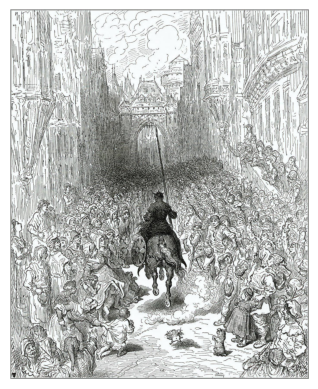

Image: gustave-dore_orlando-furioso-8.jpg
Style:  Real (Romanticism) | Pred (Romanticism) ✅
Artist: Real (gustave-dore) | Pred (gustave-dore) ✅


In [24]:
import random

def predict_random_image():
    random_idx = random.randint(0, len(val_samples) - 1)
    
    img_path, true_style_idx, true_artist_str = val_samples[random_idx]
    
    
    true_style_name = os.path.basename(os.path.dirname(img_path))
    
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tensor = val_tfms(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        s_out, a_out = model(tensor)
        s_prob = torch.softmax(s_out, 1)
        a_prob = torch.softmax(a_out, 1)
    
    pred_style = selected_classes[s_prob.argmax().item()]
    pred_artist = artist_encoder.inverse_transform([a_prob.argmax().item()])[0]
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print(f"Image: {os.path.basename(img_path)}")
    
    is_style_correct = "✅" if pred_style == true_style_name else "❌"
    print(f"Style:  Real ({true_style_name}) | Pred ({pred_style}) {is_style_correct}")
    
    is_artist_correct = "✅" if pred_artist == true_artist_str else "❌"
    print(f"Artist: Real ({true_artist_str}) | Pred ({pred_artist}) {is_artist_correct}")

predict_random_image()